### Trial 1

* Batch Size : 20
* Epoch : 20
* Optimizer : SGD
* Optimizer Learning Rate : 1.e-4
* Drop-out Rate : 0.4
* Momentum : 0.9

설정한 Batch Size는 20이며, 20번의 epoch 동안 SGD Optimizer를 사용하여 모델을 훈련시켰다. 그러나 accuracy가 향상되지 않고 Loss가 높게 나타났다.

#### Screw_spike model 1

In [ ]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base.trainable = False

model = models.Sequential()
model.add(base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
sgd = tf.keras.optimizers.SGD(learning_rate=1.e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
epochs = 20
hist = model.fit(train_generator, epochs=epochs, validation_data=val_generator, steps_per_epoch=len(train_images)//batch_size, validation_steps=len(val_images)//batch_size)

Epoch 1/20
234/234 [==============================] - 2175s 9s/step - loss: 0.8119 - accuracy: 0.5425 - val_loss: 0.6693 - val_accuracy: 0.5808
Epoch 2/20
234/234 [==============================] - 43s 184ms/step - loss: 0.7808 - accuracy: 0.5461 - val_loss: 0.6677 - val_accuracy: 0.5756
Epoch 3/20
234/234 [==============================] - 43s 183ms/step - loss: 0.7441 - accuracy: 0.5596 - val_loss: 0.6676 - val_accuracy: 0.5833
Epoch 4/20
234/234 [==============================] - 42s 181ms/step - loss: 0.7196 - accuracy: 0.5716 - val_loss: 0.6654 - val_accuracy: 0.5788
Epoch 5/20
234/234 [==============================] - 43s 184ms/step - loss: 0.7171 - accuracy: 0.5632 - val_loss: 0.6617 - val_accuracy: 0.5814
Epoch 6/20
234/234 [==============================] - 43s 183ms/step - loss: 0.7109 - accuracy: 0.5561 - val_loss: 0.6626 - val_accuracy: 0.5763
Epoch 7/20
234/234 [==============================] - 43s 183ms/step - loss: 0.7040 - accuracy: 0.5611 - val_loss: 0.6603 - val_acc

### Trial 2

* Batch Size : 20 -> 100
* Epoch : 10
* Optimizer : SGD
* Optimizer Learning Rate : 1.e-4 -> 0.1
* Drop-out Rate : 0.4
* Momentum : 0.9


#### Screw_spike model 2 [final]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 디렉토리 설정
data_dir = '/content/drive/MyDrive/Teamproject/padded_images'

# 클래스 이름을 폴더 이름과 동일하게 설정
classes = ['screw_spike_abnormal', 'screw_spike_normal']

# 모든 이미지 경로와 레이블 가져오기
all_images = []
all_labels = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(class_dir, fname))
            all_labels.append(class_name)

# 데이터를 학습, 검증, 테스트 세트로 분할
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)
print(len(train_labels), len(val_labels), len(test_labels))

18329 6110 6110


In [ ]:
# 데이터 제너레이터 생성 함수
def create_generator(images, labels, batch_size, is_training):
    data_gen = ImageDataGenerator(horizontal_flip=is_training,
                                  rotation_range=35 if is_training else 0,
                                  rescale=1./255,
                                  zoom_range=[0.7, 1.5] if is_training else [1.0, 1.0],
                                  brightness_range=(0.7, 1.0) if is_training else None,
                                  width_shift_range=0.1 if is_training else 0,
                                  height_shift_range=0.1 if is_training else 0)

    generator = data_gen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': images, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=(150, 150),  # 여기에서 이미지 크기를 150x150으로 조정
        batch_size=batch_size,
        class_mode='binary',
        shuffle=is_training)

    return generator

batch_size = 100

# 학습, 검증, 테스트 제너레이터 생성
train_generator = create_generator(train_images, train_labels, batch_size, is_training=True)
val_generator = create_generator(val_images, val_labels, batch_size, is_training=False)
test_generator = create_generator(test_images, test_labels, batch_size, is_training=False)

Found 18329 validated image filenames belonging to 2 classes.
Found 6110 validated image filenames belonging to 2 classes.
Found 6110 validated image filenames belonging to 2 classes.


In [ ]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base.trainable = False

model = models.Sequential()
model.add(base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
epochs = 10
hist = model.fit(train_generator, epochs=epochs, validation_data=val_generator, steps_per_epoch=len(train_images)//batch_size, validation_steps=len(val_images)//batch_size)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
183/183 [==============================] - 6311s 34s/step - loss: 0.4135 - accuracy: 0.9431 - val_loss: 0.1689 - val_accuracy: 0.9687
Epoch 2/10
183/183 [==============================] - 173s 942ms/step - loss: 0.1400 - accuracy: 0.9633 - val_loss: 0.1035 - val_accuracy: 0.9749
Epoch 3/10
183/183 [==============================] - 172s 938ms/step - loss: 0.1343 - accuracy: 0.9672 - val_loss: 0.0973 - val_accuracy: 0.9787
Epoch 4/10
183/183 [==============================] - 171s 935ms/step - loss: 0.1461 - accuracy: 0.9673 - val_loss: 0.1052 - val_accuracy: 0.9744
Epoch 5/10
183/183 [==============================] - 169s 921ms/step - loss: 0.1413 - accuracy: 0.9628 - val_loss: 0.1070 - val_accuracy: 0.9746
Epoch 6/10
183/183 [==============================] - 173s 947ms/step - loss: 0.1285 - accuracy: 0.9670 - val_loss: 0.0874 - val_accuracy: 0.9807
Epoch 7/10
183/183 [==============================] - 169s 9

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/Teamproject/screw_spike_model.h5')

1/1 [==============================] - 1s 1s/step


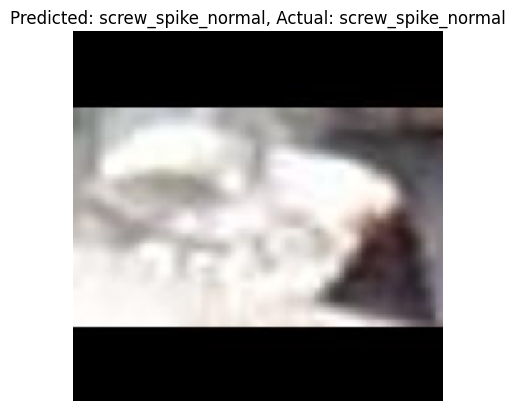

In [ ]:
import matplotlib.pyplot as plt

# 테스트 이미지와 정답 레이블 하나 선택
test_image_path = test_images[0]
test_label = test_labels[0]

# 이미지 로드 및 전처리
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 동일한 전처리 적용

# 예측값 계산
prediction = model.predict(img_array)
predicted_label = 'screw_spike_abnormal' if prediction[0] < 0.5 else 'screw_spike_normal'

# 이미지 출력
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}, Actual: {test_label}')
plt.axis('off')
plt.show()

In [ ]:
batch_size = 100

# 학습, 검증, 테스트 제너레이터 생성
train_generator = create_generator(train_images, train_labels, batch_size, is_training=True)
val_generator = create_generator(val_images, val_labels, batch_size, is_training=False)
test_generator = create_generator(test_images, test_labels, batch_size, is_training=False)

# 저장된 모델 불러오기
model_path = '/content/drive/MyDrive/Teamproject/screw_spike_model.h5'
model = load_model(model_path)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')


Found 18329 validated image filenames belonging to 2 classes.
Found 6110 validated image filenames belonging to 2 classes.
Found 6110 validated image filenames belonging to 2 classes.
62/62 [==============================] - 1818s 29s/step - loss: 0.0682 - accuracy: 0.9874
Test accuracy: 0.9873977303504944


62/62 [==============================] - 1748s 28s/step
Classification Report:
                      precision    recall  f1-score   support

screw_spike_abnormal       0.99      0.89      0.94       646
  screw_spike_normal       0.99      1.00      0.99      5464

            accuracy                           0.99      6110
           macro avg       0.99      0.95      0.97      6110
        weighted avg       0.99      0.99      0.99      6110

F1 Score: 0.9871204443823142


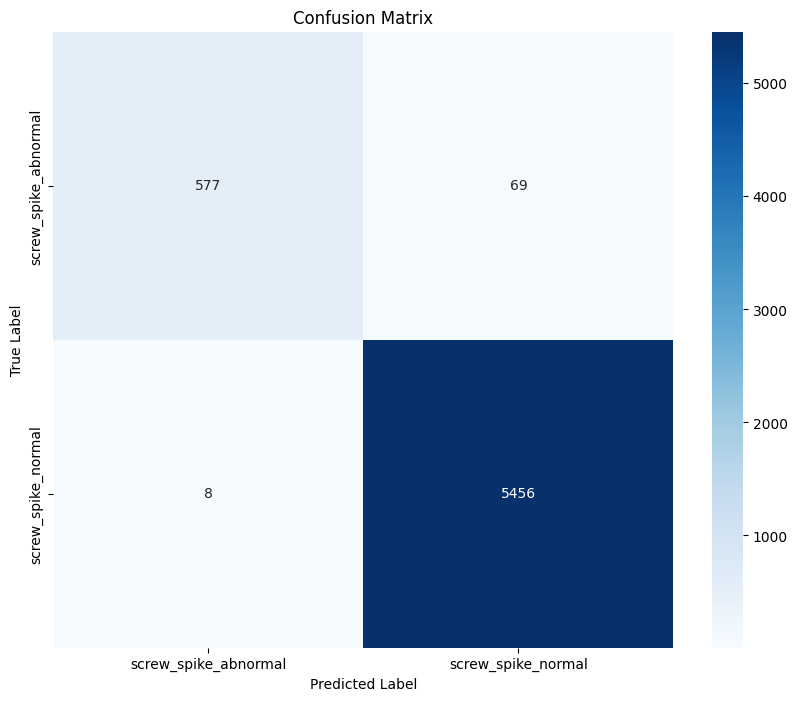

In [ ]:
# 예측 수행 및 성능 평가
y_true = []
y_pred = []


# 예측 수행 및 성능 평가
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # 이진 분류에서 확률을 이진 값으로 변환



# 성능 평가
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))
print("F1 Score:", f1_score(y_true, y_pred_classes, average='weighted'))

# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)

#### Bolt_nut model [final]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 디렉토리 설정
data_dir = '/content/drive/MyDrive/Deeplearning/Teamproject/padded_images'

# 클래스 이름을 폴더 이름과 동일하게 설정
classes = ['bolt-nut_abnormal', 'bolt-nut_normal']

# 모든 이미지 경로와 레이블 가져오기
all_images = []
all_labels = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(class_dir, fname))
            all_labels.append(class_name)

# 데이터를 학습, 검증, 테스트 세트로 분할
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)
print(len(train_labels), len(val_labels), len(test_labels))

17409 5804 5804


In [ ]:
# 데이터 제너레이터 생성 함수
def create_generator(images, labels, batch_size, is_training):
    data_gen = ImageDataGenerator(horizontal_flip=is_training,
                                  rotation_range=35 if is_training else 0,
                                  rescale=1./255,
                                  zoom_range=[0.7, 1.5] if is_training else [1.0, 1.0],
                                  brightness_range=(0.7, 1.0) if is_training else None,
                                  width_shift_range=0.1 if is_training else 0,
                                  height_shift_range=0.1 if is_training else 0)

    generator = data_gen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': images, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=(150, 150),  # 여기에서 이미지 크기를 150x150으로 조정
        batch_size=batch_size,
        class_mode='binary',
        shuffle=is_training)

    return generator

batch_size = 100

# 학습, 검증, 테스트 제너레이터 생성
train_generator = create_generator(train_images, train_labels, batch_size, is_training=True)
val_generator = create_generator(val_images, val_labels, batch_size, is_training=False)
test_generator = create_generator(test_images, test_labels, batch_size, is_training=False)

Found 17409 validated image filenames belonging to 2 classes.
Found 5804 validated image filenames belonging to 2 classes.
Found 5804 validated image filenames belonging to 2 classes.


In [ ]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base.trainable = False

model = models.Sequential()
model.add(base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
epochs = 10
hist = model.fit(train_generator, epochs=epochs, validation_data=val_generator, steps_per_epoch=len(train_images)//batch_size, validation_steps=len(val_images)//batch_size)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
174/174 [==============================] - 5741s 33s/step - loss: 0.3394 - accuracy: 0.8713 - val_loss: 0.3251 - val_accuracy: 0.9160
Epoch 2/10
174/174 [==============================] - 153s 881ms/step - loss: 0.2631 - accuracy: 0.9028 - val_loss: 0.2198 - val_accuracy: 0.9355
Epoch 3/10
174/174 [==============================] - 152s 873ms/step - loss: 0.2425 - accuracy: 0.9102 - val_loss: 0.1811 - val_accuracy: 0.9395
Epoch 4/10
174/174 [==============================] - 153s 877ms/step - loss: 0.2261 - accuracy: 0.9177 - val_loss: 0.1703 - val_accuracy: 0.9412
Epoch 5/10
174/174 [==============================] - 154s 883ms/step - loss: 0.2151 - accuracy: 0.9237 - val_loss: 0.1708 - val_accuracy: 0.9424
Epoch 6/10
174/174 [==============================] - 153s 878ms/step - loss: 0.2142 - accuracy: 0.9217 - val_loss: 0.1630 - val_accuracy: 0.9452
Epoch 7/10
174/174 [==============================] - 154s 8

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/Deeplearning/Teamproject/bolt-nut_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
batch_size = 100

# 학습, 검증, 테스트 제너레이터 생성
train_generator = create_generator(train_images, train_labels, batch_size, is_training=True)
val_generator = create_generator(val_images, val_labels, batch_size, is_training=False)
test_generator = create_generator(test_images, test_labels, batch_size, is_training=False)

# 저장된 모델 불러오기
model_path = '/content/drive/MyDrive/Deeplearning/Teamproject/bolt-nut_model.h5'
model = load_model(model_path)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')


Found 17409 validated image filenames belonging to 2 classes.
Found 5804 validated image filenames belonging to 2 classes.
Found 5804 validated image filenames belonging to 2 classes.
59/59 [==============================] - 16s 263ms/step - loss: 0.1418 - accuracy: 0.9533
Test accuracy: 0.9533080458641052


59/59 [==============================] - 15s 261ms/step
Classification Report:
                   precision    recall  f1-score   support

bolt-nut_abnormal       0.95      0.80      0.87      1158
  bolt-nut_normal       0.95      0.99      0.97      4646

         accuracy                           0.95      5804
        macro avg       0.95      0.90      0.92      5804
     weighted avg       0.95      0.95      0.95      5804

F1 Score: 0.9517560077612269


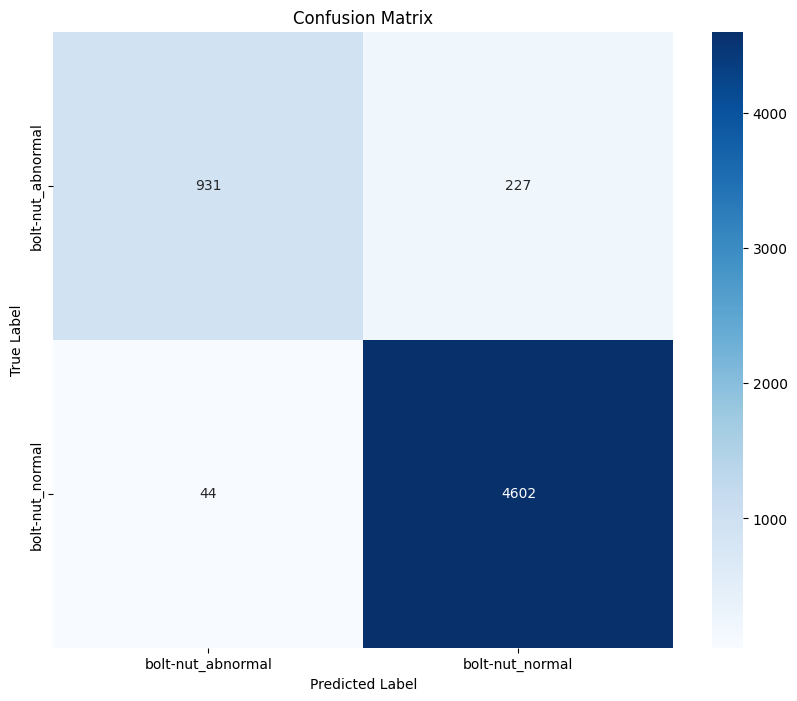

In [ ]:
# 예측 수행 및 성능 평가
y_true = []
y_pred = []


# 예측 수행 및 성능 평가
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # 이진 분류에서 확률을 이진 값으로 변환



# 성능 평가
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))
print("F1 Score:", f1_score(y_true, y_pred_classes, average='weighted'))

# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)


### Trial 3

* Batch Size :100 -> 20
* Epoch : 10
* Optimizer : SGD
* Optimizer Learning Rate : 0.01 -> 1.e-4
* Drop-out Rate : 0.4
* Momentum : 0.9

아래의 코드는 tie 부품을 학습시키는 과정을 담고 있다. 코드는 크게 데이터 로딩, 모델 정의, 데이터 제너레이터 생성, 모델 컴파일, 모델 학습 단계로 구성된다. fishplate class도 위와 동일한 설정값으로 학습시켰다.



#### Tie model [final]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 디렉토리 설정
data_dir = '/content/drive/MyDrive/DL/project/Teamproject/padded_images'

# 클래스 이름을 폴더 이름과 동일하게 설정
classes = ['tie_abnormal', 'tie_normal']

# 모든 이미지 경로와 레이블 가져오기
all_images = []
all_labels = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(class_dir, fname))
            all_labels.append(class_name)

# 데이터를 학습, 검증, 테스트 세트로 분할
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)
print(len(train_labels), len(val_labels), len(test_labels))

14688 4896 4897


In [ ]:
# 데이터 제너레이터 생성 함수
def create_generator(images, labels, batch_size, is_training):
    data_gen = ImageDataGenerator(horizontal_flip=is_training,
                                  rotation_range=35 if is_training else 0,
                                  rescale=1./255,
                                  zoom_range=[0.7, 1.5] if is_training else [1.0, 1.0],
                                  brightness_range=(0.7, 1.0) if is_training else None,
                                  width_shift_range=0.1 if is_training else 0,
                                  height_shift_range=0.1 if is_training else 0)

    generator = data_gen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': images, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=(150, 150),  # 여기에서 이미지 크기를 150x150으로 조정
        batch_size=batch_size,
        class_mode='binary',
        shuffle=is_training)

    return generator

batch_size = 20

# 학습, 검증, 테스트 제너레이터 생성
train_generator = create_generator(train_images, train_labels, batch_size, is_training=True)
val_generator = create_generator(val_images, val_labels, batch_size, is_training=False)
test_generator = create_generator(test_images, test_labels, batch_size, is_training=False)

Found 14688 validated image filenames belonging to 2 classes.
Found 4896 validated image filenames belonging to 2 classes.
Found 4897 validated image filenames belonging to 2 classes.


In [ ]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base.trainable = False

model = models.Sequential()
model.add(base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
sgd = tf.keras.optimizers.SGD(learning_rate=1.e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
epochs = 10
hist = model.fit(train_generator, epochs=epochs, validation_data=val_generator, steps_per_epoch=len(train_images)//batch_size, validation_steps=len(val_images)//batch_size)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
734/734 [==============================] - 12666s 17s/step - loss: 0.4800 - accuracy: 0.8151 - val_loss: 0.3947 - val_accuracy: 0.8494
Epoch 2/10
734/734 [==============================] - 142s 193ms/step - loss: 0.4212 - accuracy: 0.8380 - val_loss: 0.3776 - val_accuracy: 0.8512
Epoch 3/10
734/734 [==============================] - 141s 192ms/step - loss: 0.4029 - accuracy: 0.8439 - val_loss: 0.3633 - val_accuracy: 0.8508
Epoch 4/10
734/734 [==============================] - 143s 194ms/step - loss: 0.3939 - accuracy: 0.8449 - val_loss: 0.3562 - val_accuracy: 0.8525
Epoch 5/10
734/734 [==============================] - 141s 192ms/step - loss: 0.3807 - accuracy: 0.8506 - val_loss: 0.3531 - val_accuracy: 0.8539
Epoch 6/10
734/734 [==============================] - 141s 193ms/step - loss: 0.3764 - accuracy: 0.8497 - val_loss: 0.3507 - val_accuracy: 0.8545
Epoch 7/10
734/734 [==============================] - 142s 

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/DL/project/bolt_nut_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step


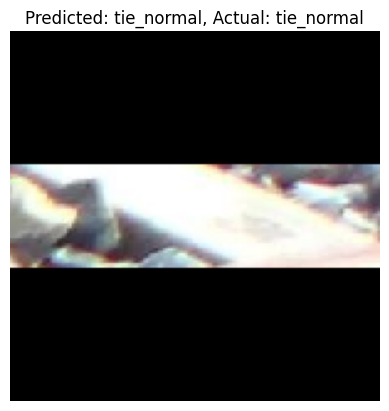

In [ ]:
import matplotlib.pyplot as plt

# 테스트 이미지와 정답 레이블 하나 선택
test_image_path = test_images[0]
test_label = test_labels[0]

# 이미지 로드 및 전처리
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # 동일한 전처리 적용

# 예측값 계산
prediction = model.predict(img_array)
predicted_label = 'tie_abnormal' if prediction[0] < 0.5 else 'tie_normal'

# 이미지 출력
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}, Actual: {test_label}')
plt.axis('off')
plt.show()